# Working with polygons

At the core of each `pyTDGL` simulation is an instance of the `tdgl.Device` class, which represents the superconducting structure to be modeled. A `Device` is composed a `Layer` that lies in a plane parallel to the $x-y$ plane (at position `layer.z0`) and has a specified thickness $d$, coherence length $\xi$ and London penetration depth $\lambda$. The layer contains superconducting `film`, which can contain zero or more `holes`. `Films` and `holes` are represented by instances of the `tdgl.Polygon` class, which defines a 2D polygonal region.

In [1]:
%config InlineBackend.figure_formats = {"retina", "png"}
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import tdgl

A `Polygon` is defined by a collection of `(x, y)` coordinates specifying its vertices; the vertices are stored as an `n x 2` `numpy.ndarray` called `polygon.points`.

In [2]:
# Define the initial geometry: a rectangular box specified as an np.ndarray
width, height = 10, 2
points = tdgl.geometry.box(width, height)
print(f"type(points) = {type(points)}, points.shape = {points.shape}")

type(points) = <class 'numpy.ndarray'>, points.shape = (100, 2)


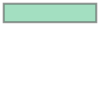

In [3]:
# Create a Polygon representing a "horizontal bar", hbar
hbar = tdgl.Polygon(points=points)
hbar.polygon

The object passed to `tdgl.Polygon(points=...)` can be of any of the following:

- An `n x 2` array-like object, for example an `np.ndarray` or a list of `(x, y)` coordinates
- An existing `tdgl.Polygon` instance (in which case, the new object will be a copy of the existing one)
- An instance of [LineString](https://shapely.readthedocs.io/en/stable/manual.html#LineString), [LinearRing](https://shapely.readthedocs.io/en/stable/manual.html#LinearRing), or [Polygon](https://shapely.readthedocs.io/en/stable/manual.html#Polygon) from the [shapely](https://shapely.readthedocs.io/en/stable/manual.html) package

In [4]:
(
    tdgl.Polygon(points=hbar.points)
    == tdgl.Polygon(points=hbar.polygon)
    == tdgl.Polygon(points=hbar)
    == hbar.copy()
    == hbar
)

True

Every instance of `tdgl.Polygon` has a property, `instance.polygon`, which returns a corresponding `shapely`
`Polygon` object. Among other things, this is usefuly for quickly visualizing polygons.

There are several methods for transforming the geometry of a single `Polygon`:

- `polygon.translate(dx=0, dy=0)`
- `polygon.rotate(degrees, origin=(0, 0))`
- `polygon.scale(xfact=1, yfact=1, origin=(0, 0))`
- `polygon.buffer(distance, ...)`

There are also three methods for combining multiple `Polygon`-like objects:

- `polygon.union(*others)`: logical union of `polygon` with each object in the iterable `others`
 - See also: `tdgl.Polygon.from_union([...])`
- `polygon.intersection(*others)`: logical intersection of `polygon` with each object in the iterable `others`
 - See also: `tdgl.Polygon.from_intersection([...])`
- `polygon.difference(*others)`: logical difference of `polygon` with each object in the iterable `others`
 - See also: `tdgl.Polygon.from_difference([...])`
 
Note that the elements of the iterable `others` can be of any type that can be passed in to `tdgl.Polygon(points=...)` (see above).

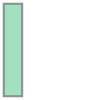

In [5]:
# Copy hbar and rotate the copy 90 degrees counterclockwise
vbar = hbar.rotate(90)
vbar.polygon

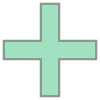

In [6]:
# Create a new Polygon that is the union of hbar and vbar: "+"
plus = hbar.union(vbar)
# # The above is equivalent to either of the following:
# plus = vbar.union(hbar)
# plus = tdgl.Polygon.from_union([hbar, vbar])
plus.polygon

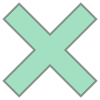

In [7]:
# Rotate the "+" by 45 degrees to make an "X"
X = plus.rotate(45)
X.polygon

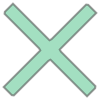

In [8]:
# Create a new polygon with all edges offset (eroded) by a distance of -0.5
thinX = X.buffer(-0.5)
thinX.polygon

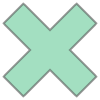

In [9]:
# Create a new polygon with all edges offset (expanded) by a distance of 0.5
thickX = X.buffer(0.5)
thickX.polygon

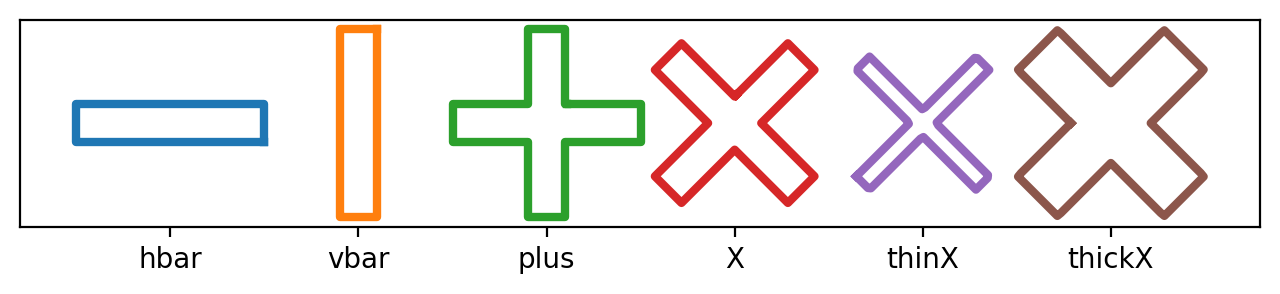

In [10]:
polygons = [hbar, vbar, plus, X, thinX, thickX]
labels = ["hbar", "vbar", "plus", "X", "thinX", "thickX"]

fig, ax = plt.subplots(figsize=(8, 1.5))

for i, polygon in enumerate(polygons):
    polygon.translate(dx=width * i).plot(ax=ax, linewidth=3)

ax.set_xticks([width * i for i, _ in enumerate(labels)])
ax.set_xticklabels(labels)
_ = ax.set_yticks([])

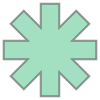

In [11]:
X.union(plus).polygon

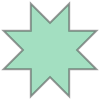

In [12]:
X.intersection(plus).polygon

Using the methods demonstrated above, intricate geometries can be constructed from simple building blocks in just a few lines of code.

In [13]:
size = 10

hbar = tdgl.Polygon(points=tdgl.geometry.box(size / 3, size / 50))
plus = hbar.union(hbar.rotate(90))
star = plus.union(plus.rotate(45))

star_dx = 1.2 * size * np.sqrt(2) / 2

snowflake = (
    tdgl.Polygon(points=tdgl.geometry.box(size, size))
    .rotate(45)
    .union(
        *(star.translate(dx=star_dx).rotate(degrees) for degrees in [0, 90, 180, 270])
    )
)
snowflake = snowflake.union(snowflake.rotate(45))

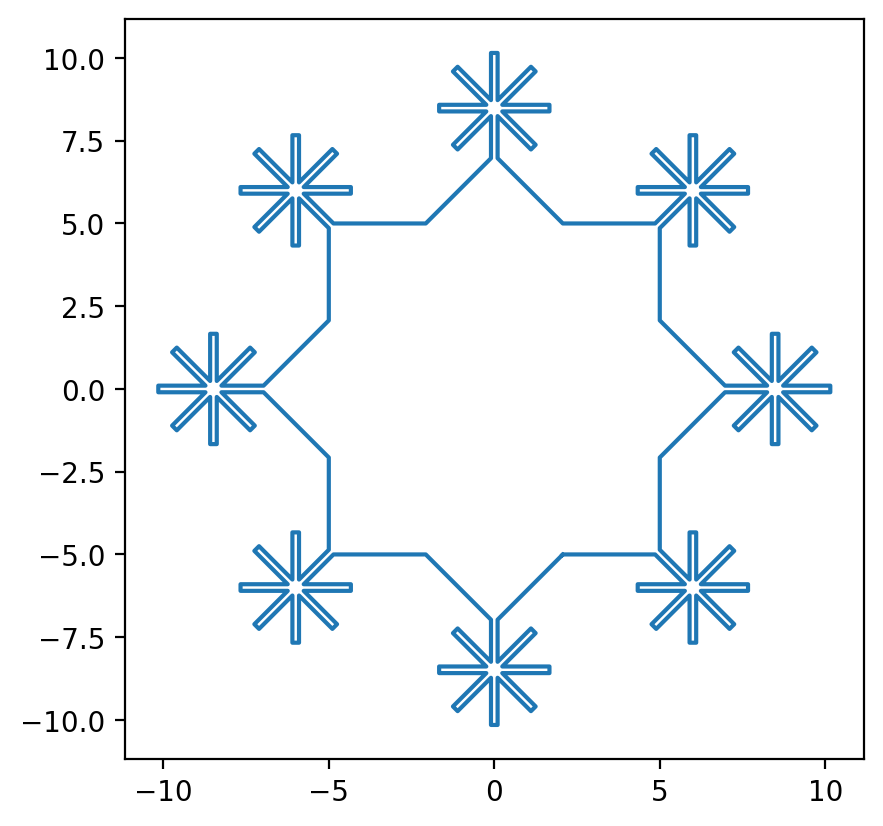

In [14]:
ax = snowflake.plot()

In [15]:
print(f"Polygon area: snowflake.area = {snowflake.area:.3f}")
print(f"Polygon width and height: snowflake.extents = {snowflake.extents}")

Polygon area: snowflake.area = 136.622
Polygon width and height: snowflake.extents = (20.303896081810475, 20.303896081810475)


## Meshing `Polygons`

Individual polygons can be meshed using the `Polygon.make_mesh()` method.

Constructing Voronoi polygons: 100%|████████████████████████████████████████████████████████████████████████████| 459/459 [00:00<00:00, 17240.11it/s]


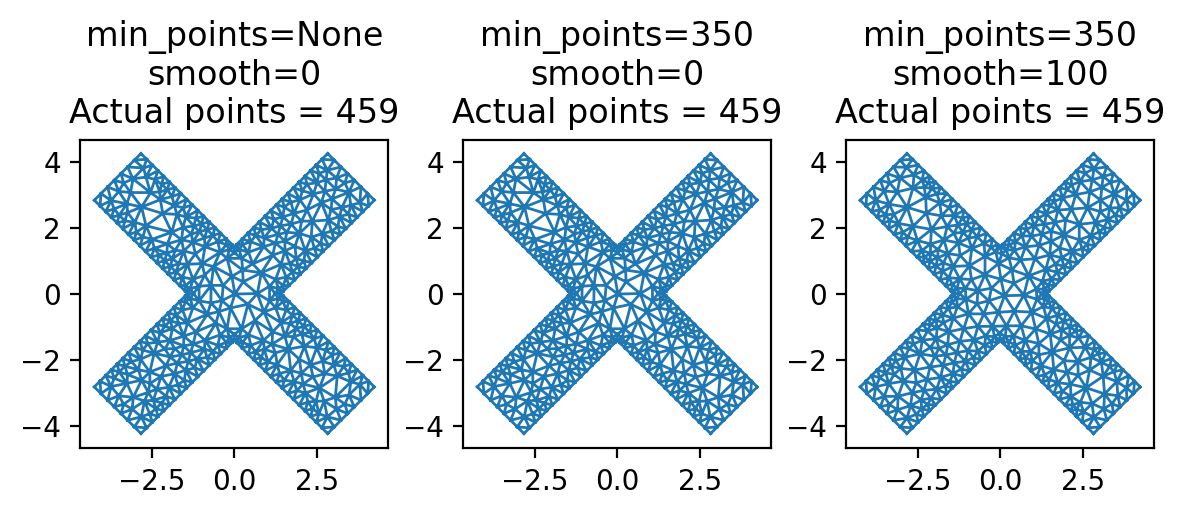

In [16]:
setups = [
    dict(min_points=None, smooth=0),
    dict(min_points=350, smooth=0),
    dict(min_points=350, smooth=100),
]

fig, axes = plt.subplots(1, len(setups), figsize=(2 * (len(setups) + 0.5), 2))

for ax, options in zip(axes, setups):
    # Generate a mesh with the specified options
    mesh = X.make_mesh(**options)

    # Plot the mesh
    ax.set_aspect("equal")
    title = [f"{key}={value!r}" for key, value in options.items()]
    title.append(f"Actual points = {mesh.x.shape[0]}")
    ax.triplot(mesh.x, mesh.y, mesh.elements, lw=1)
    ax.set_title("\n".join(title))

In [17]:
tdgl.version_table()

Software,Version
tdgl,0.8.0; git revision 7c3bdaa [2023-10-27]
Numpy,1.24.3
SciPy,1.10.1
matplotlib,3.7.1
cupy,None
numba,0.57.1
IPython,8.14.0
Python,"3.10.11 | packaged by conda-forge | (main, May 10 2023, 19:01:19) [Clang 14.0.6 ]"
OS,posix [darwin]
Number of CPUs,"Physical: 10, Logical: 10"
